In [2]:
# Importing the necessary libraries for the project. 
import pandas as pd 
import yfinance as yf
import numpy as np # for numerical operations
import seaborn as sns #visualisation
import matplotlib.pyplot as plt # visualization
%matplotlib inline 
import matplotlib.ticker as ticker # Library to customize ticks
from datetime import date
import matplotlib.dates as mdates
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from math import sqrt
# Mean Squared Error and Mean Absolute Error metrics from sklearn for evaluating model accuracy.
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
from sklearn.metrics import mean_squared_error, mean_absolute_error
# TimeSeriesSplit for cross-validation with time series data to preserve the temporal ordering of data.
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterSampler
from tensorflow.keras.optimizers import Adam
from keras.layers import BatchNormalization, Dropout, Dense, LSTM, GRU
import random
import optuna
from optuna.samplers import TPESampler
from keras_tuner import BayesianOptimization

import warnings # filter warnings
warnings.filterwarnings('ignore')

In [4]:
# Importing the dataset after the Log Returns transformation.
df1 = pd.read_csv('df1.csv', index_col=0, parse_dates=True)

# Along with the importation, the code will set the date as the index, value of 0 because is the first column.
## Setting parse_dates=true to ensure the dates are in datetime, making more appropriate for ML models.

In [3]:
df1.describe()

,Close,lag_1,lag_4,rolling_mean_4w,rolling_mean_12w,volatility_4w
count,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000
mean,0.001575,0.001608,0.001508,0.001578,0.001516,7.731465
std,0.020723,0.020744,0.020750,0.009796,0.005364,23.505939
min,-0.069935,-0.069935,-0.069935,-0.051352,-0.026288,0.154122
25%,-0.007633,-0.007633,-0.007858,-0.003032,-0.001013,1.538535
50%,0.003635,0.003666,0.003626,0.002937,0.002346,2.585030
75%,0.013568,0.013643,0.013514,0.007596,0.004979,6.157669
max,0.051947,0.051947,0.051947,0.031089,0.019145,338.128664


In [6]:
# Define the selected exogenous variables and target variable.
features = df1[['rolling_mean_4w', 'rolling_mean_12w', 'volatility_4w', 'lag_1', 'lag_4']]
target = df1['Close']

#### Comparison of Scaling Techniques (All have sequence length of 4)

| **Metrics**        | **Robust Scaling** | **Standard Scaling** | **MinMax Scaling** |
|---------------------|--------------------|-----------------------|--------------------|
| **Train RMSE**      | 0.020148595       | 0.020128678          | 0.020419093       |
| **Test RMSE**       | 0.022906913       | 0.022446095          | 0.023013218       |
| **Train MAE**       | 0.014546276       | 0.014421072          | 0.01485473        |
| **Test MAE**        | 0.017450262       | 0.016954642          | 0.017467919       |
| **Train Loss**      | 1.105406404       | 0.89046818           | 0.111690558       |
| **Validation Loss** | 1.088732004       | 1.31695807           | 0.130892992       |
| **Avg RMSE - TSCV** | 1.072480028       | 1.049797895          | 0.365968045       |
| **Avg RMSE - FRWCV**| 0.946568711       | 0.92217397           | 0.348539135       |
| **Train DA**        | 60%               | 63%                  | 56%               |
| **Test DA**         | 61%               | 59%                  | 58%               |

The table above is the best performers of each scaling technique, which was tested in LSTM using different sequence length to find which approach can be used for other LSTM extensions Gated Recurrent Unit (GRU) and Bidirectional LSTM (Bi-LSTM). According to the results **the scaling method to be used onwards is the Standard Scaler. According to the results of the experiment using three different scalers (LSTM model), it was identified that the scaler had better accuracy (RMSE and MAE) performance, the cross validation scores also were satisfatory. In addition, the curve of validation loss did not increase througout the epochs..** 

In [8]:
# Split data into training and testing sets, same ratio applied in SARIMAX.
train_size = int(0.85 * len(features))
X_train, X_test = features[:train_size], features[train_size:]
y_train, y_test = target[:train_size], target[train_size:]

# Initialize and fit RobustScalers to scale data with reduced sensitivity to outliers.
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit scalers on training data and transform both training and test data.
X_train_scaled = scaler_X.fit_transform(X_train) # Fit scaler on training features and transform.
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)) # Fit scaler on training target and transform.

# Transform test data without fitting again to avoid data leakage.
X_test_scaled = scaler_X.transform(X_test) # Transform test features using the scaler fitted on training data.
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)) # Transform test target using the scaler fitted on training data

# Print minimum and maximum values of the scaled training and test data for verification.
print("Scaled Training Features - Min:", X_train_scaled.min(), "Max:", X_train_scaled.max())
print("Scaled Training Target - Min:", y_train_scaled.min(), "Max:", y_train_scaled.max())
print("Scaled Test Features - Min:", X_test_scaled.min(), "Max:", X_test_scaled.max())
print("Scaled Test Target - Min:", y_test_scaled.min(), "Max:", y_test_scaled.max())

Scaled Training Features - Min: -5.4955652189278625 Max: 9.795796286704956
Scaled Training Target - Min: -3.526234546763028 Max: 2.4845799166596207
Scaled Test Features - Min: -3.5237835824322223 Max: 29.172000533821247
Scaled Test Target - Min: -3.526234546763028 Max: 2.4845799166596207


## Sequence Length = 4 

In [12]:
# Set the sequence length for GRU input, representing the number of time steps.
sequence_length = 4  # Number of time steps used for target prediction, 4 weeks.

# Reshape data into sequences for GRU.
# Initialize empty lists to hold the sequences for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the training data to create sequences of features and corresponding target values.
for i in range(len(X_train_scaled) - sequence_length):
    # Append a sequence of features for the current window.
    X_train_seq.append(X_train_scaled[i:i + sequence_length]) # Sequence of features.
    # Append the target value that comes immediately after the sequence.
    y_train_seq.append(y_train_scaled[i + sequence_length]) # Target value following the sequence.
# Initialize empty lists to hold the sequences for the test set    
X_test_seq, y_test_seq = [], []
# Same process for the test sets.
for i in range(len(X_test_scaled) - sequence_length):
    # Append a sequence of features for the current window in the test set.
    X_test_seq.append(X_test_scaled[i:i + sequence_length])
    # Append the target value immediately after the sequence in the test set.
    y_test_seq.append(y_test_scaled[i + sequence_length])

# Convert lists to numpy arrays to use in Neural Networks.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input data for GRU.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}")
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}")
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")
print(f"Reshaped  y_test_seq shape: { y_test_seq.shape}")

Reshaped X_train_seq shape: (872, 4, 5)
Reshaped y_train_seq shape: (872, 1)
Reshaped X_test_seq shape: (151, 4, 5)
Reshaped  y_test_seq shape: (151, 1)


### 1. Random Search (Two Layers - Model 1)

In [10]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the GRU model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First GRU layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(GRU(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second GRU layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(GRU(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.01, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 5.0, 'batch_size': 64}
Final Training Loss: 1.0944353342056274
Final Validation Loss: 1.34613037109375
Running combination 2/30: {'units2': 128, 'units1': 64, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.001, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 2.359327554702759
Final Validation Loss: 2.253361225128174
Running combination 3/30: {'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 1.0, 'batch_size': 64}
Final Training Loss: 1.1116318702697754
Final Validation Loss: 1.3216654062271118
Running combination 4/30

In [168]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 64,
    'units2': 32,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 1.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=params['units2'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - loss: 3.2780 - val_loss: 1.3805
Epoch 2/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.1356 - val_loss: 1.3767
Epoch 3/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0223 - val_loss: 1.3587
Epoch 4/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.7966 - val_loss: 1.3614
Epoch 5/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6196 - val_loss: 1.3508
Epoch 6/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5142 - val_loss: 1.3434
Epoch 7/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4000 - val_loss: 1.3646
Epoch 8/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3424 - val_loss: 1.3581
Epoch 9/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4253 - val_loss: 1.3408
Epoch 10/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3098 - val_loss: 1.3368
Epoch 11/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3149 - val_loss: 1.3344
Epoch 12/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step -

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
GRU Model Performance:
Training RMSE: 0.02013538961763738
Test RMSE: 0.022516987013561682
Training MAE: 0.01449091767326056
Test MAE: 0.017158276096701702
Directional Accuracy on Training Data: 67.04936854190585%
Directional Accuracy on Test Data: 60.66666666666667%


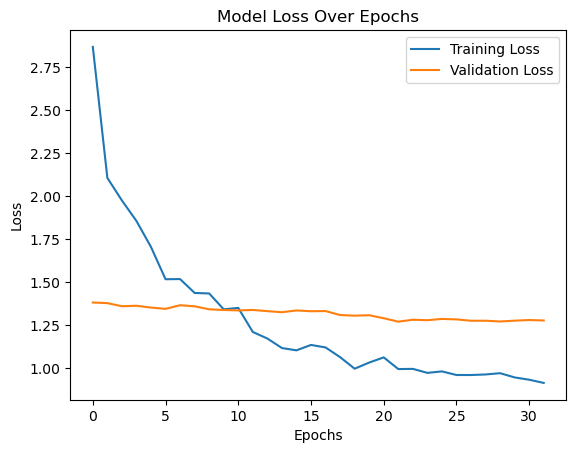

In [169]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("GRU Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Three Layers (Model 2)

In [14]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units3': 32, 'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 5.0, 'batch_size': 32}
Final Training Loss: 0.9974836707115173
Final Validation Loss: 1.3651988506317139
Running combination 2/30: {'units3': 128, 'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0001, 'l2_lambda': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 3.941298246383667
Final Validation Loss: 3.632852077484131
Running combination 3/30: {'units3': 128, 'units2': 64, 'units1': 64, 'recurrent_dropout': 0.1, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.4, 'clipnorm': 5.0, 'batch_size': 256}
Final Training Loss: 2.6545615196228027
Final Valida

In [200]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 100,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=params['units2'], return_sequences=True, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=params['units3'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 224ms/step - loss: 3.1089 - val_loss: 1.2391
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 2.1597 - val_loss: 1.2457
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 1.9458 - val_loss: 1.2406
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.7605 - val_loss: 1.2402
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 1.8405 - val_loss: 1.2403
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.6299 - val_loss: 1.2362
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.7026 - val_loss: 1.2360
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.7279 - val_loss: 1.2329
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.7361 - val_loss: 1.2324
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 1.6981 - val_loss: 1.2311
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.5400 - val_loss: 1.2337
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.6029 - val_

28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
GRU Model Performance:
Training RMSE: 0.019594752836137694
Test RMSE: 0.022853752755819166
Training MAE: 0.014223517639730426
Test MAE: 0.01754732901220352
Directional Accuracy on Training Data: 62.801377726750864%
Directional Accuracy on Test Data: 56.666666666666664%


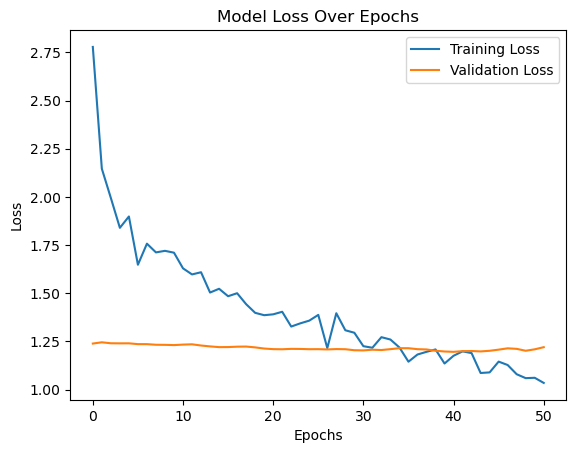

In [201]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("GRU Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2. Optuna (Model 3) 

In [18]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def gru_objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of an GRU model.
    Takes a trial object from Optuna and returns the validation loss of the model with given parameters.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate for LSTM layers.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.

    # Initialize the Sequential model.
    model = Sequential()

    # Add GRU layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add GRU layer with specified hyperparameters.
        model.add(GRU(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Set input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))

        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model with mean squared error loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(gru_objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

[I 2024-11-20 23:29:11,168] A new study created in memory with name: no-name-f796599c-9e95-4a68-9a11-72ae54605c7e
[I 2024-11-20 23:29:35,406] Trial 0 finished with value: 1.577956199645996 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0037550037026405905, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 1.577956199645996.
[I 2024-11-20 23:29:57,275] Trial 1 finished with value: 3.6004111766815186 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.04641587067816149, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 2, 'epochs': 50, 'batch_size': 256}. Best is trial 0 with value: 1.577956199645996.
[I 2024-11-20 23:30:44,570] Trial 2 finished with value: 3.683228015899658 and parameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2, 

Best hyperparameters: {'dropout_rate': 0.2, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0027183669335113948, 'learning_rate': 0.001, 'learning_rate_decay': 0, 'clipnorm': 5.0, 'units': 32, 'num_layers': 1, 'epochs': 150, 'batch_size': 120}
Best validation loss: 1.0932549238204956


In [270]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.001,
    'l2_lambda': 0.0027183669335113948,
    'epochs': 150,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters.
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping.
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False, 
    callbacks=[early_stopping]
)

# Print the final training and validation loss.
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - loss: 1.8057 - val_loss: 1.1124
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.4322 - val_loss: 1.1089
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1931 - val_loss: 1.1117
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2354 - val_loss: 1.1137
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2671 - val_loss: 1.1105
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2764 - val_loss: 1.1065
Epoch 7/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2809 - val_loss: 1.1060
Epoch 8/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2513 - val_loss: 1.1090
Epoch 9/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1872 - val_loss: 1.1077
Epoch 10/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1529 - val_loss: 1.1055
Epoch 11/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1738 - val_loss: 1.1083
Epoch 12/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2200 - val_loss

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
GRU Model Performance:
Training RMSE: 0.02025152012128893
Test RMSE: 0.02309103354681884
Training MAE: 0.014783128351052634
Test MAE: 0.017642798325616837
Directional Accuracy on Training Data: 55.33869115958668%
Directional Accuracy on Test Data: 55.333333333333336%


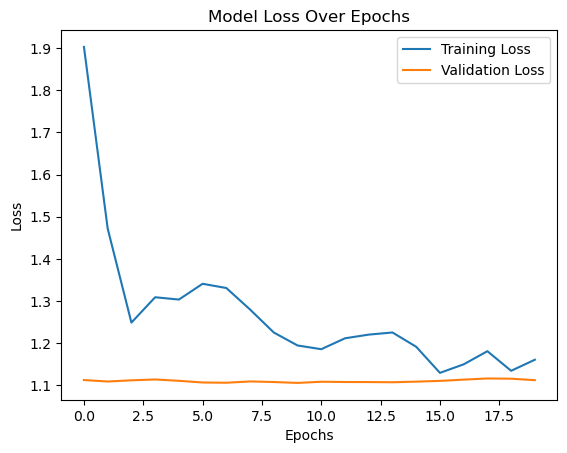

In [271]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("GRU Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 3. Keras Tuner (Model 4) 

In [22]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build model function with hyperparameter choices.
def build_gru_model_tuner(hp): #hp (kerastuner.HyperParameters) - Hyperparameter search space.
    model = Sequential()
    
    # Define hyperparameters using `hp` for various tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates to fight overfitting.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout for LSTM layers.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization factor.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate choices.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay for gradual reduction.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm to prevent exploding gradients.
    units = hp.Choice("units", [32, 64, 128])  # Number of units for LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size choices.


    # Add GRU layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)
        model.add(GRU(units=units, return_sequences=return_sequences,
                       input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
                       kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
        model.add(BatchNormalization()) # Add batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Add dropout to help with overfitting.

    model.add(Dense(1))  # Output layer for a single continuous value.
    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
     # Compile model with specified optimizer and mean squared error loss.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")
    
    return model

# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_gru_model_tuner,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of times to execute each trial.
    directory="gru_tuner_dir",  # Directory to store tuning results.
    project_name="gru_tuning_capstone",  # Tuning project name.
    overwrite=True  # Overwrite existing tuner results if present.
)

# Define early stopping.
early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

# Perform tuning with verbose logging.
tuner.search(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=200,
    callbacks=[early_stopping],
    shuffle=False,
    verbose=1  # Ensure output of each trial.
)

# Retrieve the best model and hyperparameters
best_gru_model = tuner.get_best_models(num_models=1)[0]
best_gru_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters for GRU:", best_gru_hyperparameters.values)
print("Best batch size for GRU:", best_gru_hyperparameters.get("batch_size"))

Trial 30 Complete [00h 00m 52s]
val_loss: 1.2783674001693726

Best val_loss So Far: 1.2660167217254639
Total elapsed time: 00h 23m 20s
Built model with params: dropout_rate=0.4, recurrent_dropout=0.2, l2_lambda=0.025064206402151706, learning_rate=0.0005, learning_rate_decay=1e-05, clipnorm=1.0, units=32, num_layers=3, batch_size=120
Best hyperparameters for GRU: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2, 'l2_lambda': 0.025064206402151706, 'learning_rate': 0.0005, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'batch_size': 120}
Best batch size for GRU: 120


In [204]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0005,
    'l2_lambda': 0.025064206402151706,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=params['units2'], return_sequences=True, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=params['units3'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 228ms/step - loss: 7.3353 - val_loss: 3.6899
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.1676 - val_loss: 3.6493
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.7506 - val_loss: 3.6068
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 5.8626 - val_loss: 3.5643
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 5.6220 - val_loss: 3.5219
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.5992 - val_loss: 3.4799
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 5.2273 - val_loss: 3.4399
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.1242 - val_loss: 3.3996
Epoch 9/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.0172 - val_loss: 3.3579
Epoch 10/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.6335 - val_loss: 3.3126
Epoch 11/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.7007 - val_loss: 3.2700
Epoch 12/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.4697 - val

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
GRU Model Performance:
Training RMSE: 0.02017662036983926
Test RMSE: 0.022932441747389284
Training MAE: 0.014614703615523259
Test MAE: 0.01744875272153516
Directional Accuracy on Training Data: 60.39035591274398%
Directional Accuracy on Test Data: 58.666666666666664%


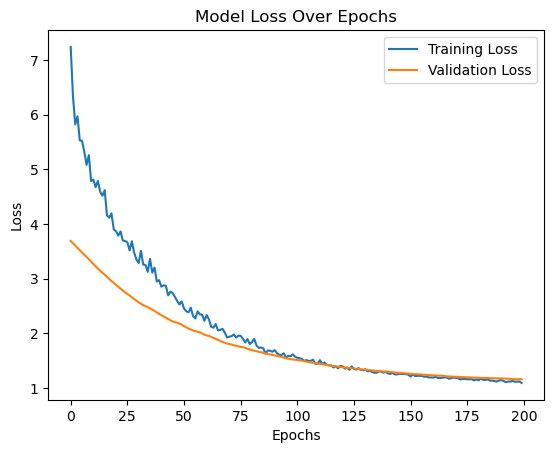

In [205]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("GRU Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Cross Validation on the Best performer (Model 1)

In [14]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Best hyperparameters
best_params = {
    'units1': 64,
    'units2': 32,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 1.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    optimizer = Adam(learning_rate=params['learning_rate'], 
                     decay=params['learning_rate_decay'], 
                     clipnorm=params['clipnorm'])
    
    # Compile the model
    model.compile(optimizer=optimizer, loss=params['loss_function'])
    
    return model

# Define the number of splits for Time Series Cross-Validation
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize the list to store RMSE scores
tscv_rmse_scores = []

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create the model once and save its initial weights
model = build_best_model(best_params)
initial_weights = model.get_weights()

# Perform TSCV
for fold, (train_index, test_index) in enumerate(tscv.split(X_train_scaled)):
    print(f"Fold {fold + 1}")

    # Reset model to initial weights
    model.set_weights(initial_weights)
    
    # Define train and test sets
    train, test = X_train_scaled[train_index], X_train_scaled[test_index]
    y_train_fold, y_test_fold = y_train_scaled[train_index], y_train_scaled[test_index]
    
    # Create sequences
    X_train_seq, y_train_seq = [], []
    for i in range(len(train) - sequence_length):
        X_train_seq.append(train[i:i + sequence_length])
        y_train_seq.append(y_train_fold[i + sequence_length])
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(test) - sequence_length):
        X_test_seq.append(test[i:i + sequence_length])
        y_test_seq.append(y_test_fold[i + sequence_length])
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        verbose=0,
        callbacks=[early_stopping]
    )
    
    # Predict and evaluate
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    tscv_rmse_scores.append(rmse)
    print(f"Fold {fold + 1} RMSE: {rmse}")

# Calculate the average RMSE across all folds
avg_rmse = np.mean(tscv_rmse_scores)
print(f"Average RMSE from TSCV: {avg_rmse}")

Fold 1
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Fold 1 RMSE: 1.3763567902253524
Fold 2
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold 2 RMSE: 0.9471602425838056
Fold 3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Fold 3 RMSE: 0.7694644160523583
Fold 4
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 4 RMSE: 1.0948834160915373
Average RMSE from TSCV: 1.0469662162382634


In [15]:
# Parameters for FRWCV
train_window = 300  # Training window size
test_window = 50    # Test window size

# Store RMSEs for each window
rolling_rmse_scores = []

for start in range(0, len(X_train_scaled) - train_window - test_window, test_window):
    print(f"Rolling window starting at index {start}")
    
    # Define train and test sets for the window
    train = X_train_scaled[start:start + train_window]
    test = X_train_scaled[start + train_window:start + train_window + test_window]
    y_train_fold = y_train_scaled[start:start + train_window]
    y_test_fold = y_train_scaled[start + train_window:start + train_window + test_window]
    
    # Create sequences for train and test
    X_train_seq, y_train_seq = [], []
    for i in range(len(train) - sequence_length):
        X_train_seq.append(train[i:i + sequence_length])
        y_train_seq.append(y_train_fold[i + sequence_length])
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(test) - sequence_length):
        X_test_seq.append(test[i:i + sequence_length])
        y_test_seq.append(y_test_fold[i + sequence_length])
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Build and train the model
    model = build_best_model(best_params)
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=best_params['epochs'], 
        batch_size=best_params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        verbose=0,  # Suppress training logs for brevity
        callbacks=[early_stopping]
    )
    
    # Evaluate on the test set
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    rolling_rmse_scores.append(rmse)
    print(f"Rolling window RMSE: {rmse}")

# Calculate average RMSE across rolling windows
avg_rolling_rmse = np.mean(rolling_rmse_scores)
print(f"Average Rolling Window RMSE: {avg_rolling_rmse}")

Rolling window starting at index 0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
Rolling window RMSE: 1.20235688430166
Rolling window starting at index 50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/stepWARNING:tensorflow:5 out of the last 23 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000016EE3B03B00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
Rolling window RMSE: 1.2545744028789392
Rolling 

In [18]:
# Extracting train and val loss:
scaled_train_loss = history.history['loss'][-1]  # Final train loss
scaled_val_loss = history.history['val_loss'][-1]  # Final validation loss

# Descale train and validation loss
descaled_train_loss = np.sqrt(scaled_train_loss) * scaler_y.scale_[0] + scaler_y.mean_[0]
descaled_val_loss = np.sqrt(scaled_val_loss) * scaler_y.scale_[0] + scaler_y.mean_[0]

print(f"Descaled Training Loss: {descaled_train_loss}")
print(f"Descaled Validation Loss: {descaled_val_loss}")

Descaled Training Loss: 0.028214655125962412
Descaled Validation Loss: 0.02880561379934771


In [20]:
# Function to descale RMSE
def descale_rmse(scaled_rmse, scaler_y):
    # Reshape RMSE value to fit scaler requirements
    scaled_rmse_array = np.array(scaled_rmse).reshape(-1, 1)
    # Inverse transform the RMSE
    descaled_rmse_array = scaler_y.inverse_transform(scaled_rmse_array)
    # Return the descaled RMSE as a list
    return descaled_rmse_array.flatten().tolist()

# Descale TSCV RMSE values
descaled_tscv_rmse = descale_rmse(tscv_rmse_scores, scaler_y)
print("Descaled TSCV RMSE Values:", descaled_tscv_rmse)

# Descale FRWCV RMSE values
descaled_frwcv_rmse = descale_rmse(rolling_rmse_scores, scaler_y)
print("Descaled FRWCV RMSE Values:", descaled_frwcv_rmse)

# Calculates average descaled RMSE
average_tscv_rmse = np.mean(descaled_tscv_rmse)
average_frwcv_rmse = np.mean(descaled_frwcv_rmse)
print(f"Average Descaled TSCV RMSE: {average_tscv_rmse}")
print(f"Average Descaled FRWCV RMSE: {average_frwcv_rmse}")

Descaled TSCV RMSE Values: [0.02947508730358308, 0.020772234407756645, 0.017169081849789103, 0.023767629071126915]
Descaled FRWCV RMSE Values: [0.02594687722486122, 0.027005696046355283, 0.019198303970471335, 0.01645223636649807, 0.01662672012019752, 0.019243444379112743, 0.018636467486687517, 0.012049349786357171, 0.016775545508730838, 0.022923625860321133, 0.028320731244188067]
Average Descaled TSCV RMSE: 0.022796008158063936
Average Descaled FRWCV RMSE: 0.020288999817616445


#### GRU - Sequence Length = 4 Models comparison 

| Metrics        | Model 1        | Model 2        | Model 3        | Model 4        |
|-----------------|----------------|----------------|----------------|----------------|
| **Train RMSE** | 0.02013539     | 0.019594753    | 0.020251520    | 0.02017662     |
| **Test RMSE**  | 0.022516987    | 0.022853753    | 0.023091033    | 0.022932442    |
| **Train MAE**  | 0.014490918    | 0.014223518    | 0.014783128    | 0.014614704    |
| **Test MAE**   | 0.017158276    | 0.017547329    | 0.017642798    | 0.017448753    |
| **Train Loss** | 0.912656903    | 1.034863949    | 1.160562038    | 1.09694159     |
| **Val Loss**   | 1.27573967     | 1.220347643    | 1.112067699    | 1.16360116     |
| **Train DA**   | 67%            | 63%            | 55%            | 60.00%         |
| **Test DA**    | 61%            | 57%            | 55%            | 59.00%         |

**Key:**
- RMSE: Root Mean Squared Error
- MAE: Mean Absolute Error
- Loss: Training or Validation Loss
- DA: Directional Accuracy
---
- By observing the metrics table, the model 1 stands out for the lower scores on the test set for RMSE and MAE, also had the lowest validation loss.
- The train and val loss plot shows that the train loss decreasess gradualy, however the val loss is plateau but does not increase.

#### Training and Validation Loss
| Metric           | Loss          |
|-------------------|---------------|
| Training Loss     | 0.02821466    |
| Validation Loss   | 0.02880561    |

---

#### TSCV RMSE Values
| Fold | RMSE          |
|------|---------------|
| 1    | 0.02947509    |
| 2    | 0.02077223    |
| 3    | 0.01716908    |
| 4    | 0.02376763    |

**Average TSCV RMSE**: **0.02279601**

- The model shows that suffers to generalize at the first fold, but is quite consistent at the remaining three. Suggesting variability in the first fold. 

#### FRWCV RMSE Values
| Window | RMSE          |
|--------|---------------|
| 1      | 0.02594688    |
| 2      | 0.02700570    |
| 3      | 0.01919830    |
| 4      | 0.01645224    |
| 5      | 0.01662672    |
| 6      | 0.01924344    |
| 7      | 0.01863647    |
| 8      | 0.01204935    |
| 9      | 0.01677555    |
| 10     | 0.02292363    |
| 11     | 0.02832073    |

**Average FRWCV RMSE**: **0.02028900**

- The higher rmse in the beginning and at the end, indicates that the the model does not handle the dataset very well, showing some flunctuation in the 1st, 2nd, 10th and 11th.   

**Model 1 is the best performer inputing sequence length of 4**.

## Sequence Length = 12 

In [23]:
# Set the sequence length for GRU input, representing the number of time steps.
sequence_length = 12  # Number of time steps used for target prediction, 12 weeks (Quarterly).

# Reshape data into sequences for GRU.
# Initialize empty lists to hold the sequences for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the training data to create sequences of features and corresponding target values.
for i in range(len(X_train_scaled) - sequence_length):
    # Append a sequence of features for the current window.
    X_train_seq.append(X_train_scaled[i:i + sequence_length]) # Sequence of features.
    # Append the target value that comes immediately after the sequence.
    y_train_seq.append(y_train_scaled[i + sequence_length]) # Target value following the sequence.
# Initialize empty lists to hold the sequences for the test set    
X_test_seq, y_test_seq = [], []
# Same process for the test sets.
for i in range(len(X_test_scaled) - sequence_length):
    # Append a sequence of features for the current window in the test set.
    X_test_seq.append(X_test_scaled[i:i + sequence_length])
    # Append the target value immediately after the sequence in the test set.
    y_test_seq.append(y_test_scaled[i + sequence_length])

# Convert lists to numpy arrays to use in Neural Networks.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)


# Print the reshaped input data for GRU.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}")
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}")
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")
print(f"Reshaped  y_test_seq shape: { y_test_seq.shape}")

Reshaped X_train_seq shape: (864, 12, 5)
Reshaped y_train_seq shape: (864, 1)
Reshaped X_test_seq shape: (143, 12, 5)
Reshaped  y_test_seq shape: (143, 1)


### 1. Random Search (Two Layers - Model 1)

In [30]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the LSTM model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First GRU layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(GRU(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second GRU layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(GRU(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.01, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 5.0, 'batch_size': 64}
Final Training Loss: 1.1785242557525635
Final Validation Loss: 1.4766939878463745
Running combination 2/30: {'units2': 128, 'units1': 64, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.001, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 2.3541805744171143
Final Validation Loss: 2.3133509159088135
Running combination 3/30: {'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 1.0, 'batch_size': 64}
Final Training Loss: 1.4023326635360718
Final Validation Loss: 1.397765040397644
Running combination 4

In [244]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 64,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 1.0,
    'batch_size': 256
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=params['units2'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 410ms/step - loss: 3.5861 - val_loss: 1.3887
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 2.6473 - val_loss: 1.3885
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 2.1452 - val_loss: 1.3817
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 2.3915 - val_loss: 1.3829
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 2.1413 - val_loss: 1.3795
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 2.0919 - val_loss: 1.3833
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 1.8607 - val_loss: 1.3813
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 1.9159 - val_loss: 1.3775
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 1.9994 - val_loss: 1.3765
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 1.8398 - val_loss: 1.3731
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 1.8534 - val_loss: 1.3747
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.8568 - val_

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step
GRU Model Performance:
Training RMSE: 0.02034039310912118
Test RMSE: 0.023200849509686164
Training MAE: 0.014789382988801256
Test MAE: 0.017475671565200288
Directional Accuracy on Training Data: 58.86442641946697%
Directional Accuracy on Test Data: 55.633802816901415%


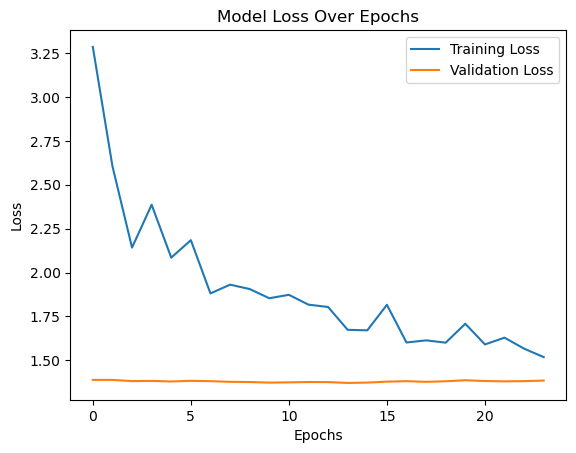

In [245]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Reshape `y_train_seq` and `y_test_seq` back to 2D
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq.reshape(-1, 1))
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1))

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("GRU Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Three Layers (Model 2)

In [34]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units3': 32, 'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 5.0, 'batch_size': 32}
Final Training Loss: 1.06593656539917
Final Validation Loss: 1.4646607637405396
Running combination 2/30: {'units3': 128, 'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0001, 'l2_lambda': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 3.8575246334075928
Final Validation Loss: 3.709118604660034
Running combination 3/30: {'units3': 128, 'units2': 64, 'units1': 64, 'recurrent_dropout': 0.1, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.4, 'clipnorm': 5.0, 'batch_size': 256}
Final Training Loss: 2.754936933517456
Final Validati

In [285]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 100,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=params['units2'], return_sequences=True, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=params['units3'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 396ms/step - loss: 3.0290 - val_loss: 1.2765
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 2.1761 - val_loss: 1.2894
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1.8525 - val_loss: 1.2887
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.8591 - val_loss: 1.2771
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.8584 - val_loss: 1.3085
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.7121 - val_loss: 1.3101
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 1.5935 - val_loss: 1.2681
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 1.6779 - val_loss: 1.2948
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 1.7243 - val_loss: 1.3117
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.5177 - val_loss: 1.2790
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.7142 - val_loss: 1.2943
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.5713 - val

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step
GRU Model Performance:
Training RMSE: 0.020315578253565662
Test RMSE: 0.023359343036471896
Training MAE: 0.014709748538639945
Test MAE: 0.01762876697974056
Directional Accuracy on Training Data: 57.242178447276935%
Directional Accuracy on Test Data: 53.52112676056338%


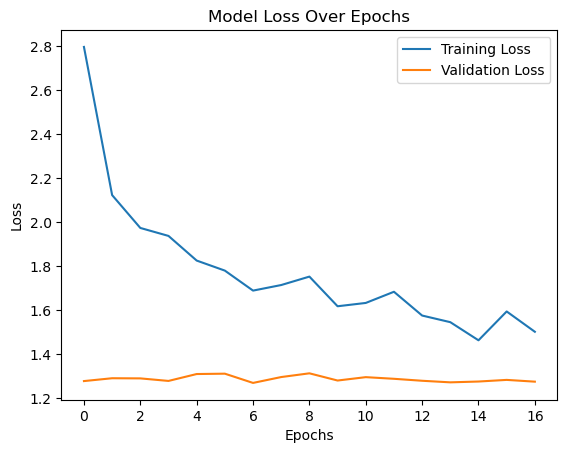

In [286]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("GRU Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2. Optuna (Model 3) 

In [38]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def gru_objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of a GRU model.
    Takes a trial object from Optuna and returns the validation loss of the model with given parameters.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate for LSTM layers.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.

    # Initialize the Sequential model.
    model = Sequential()

    # Add GRU layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add GRU layer with specified hyperparameters.
        model.add(GRU(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Set input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))

        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model with mean squared error loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(gru_objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

[I 2024-11-21 00:23:09,365] A new study created in memory with name: no-name-0ad06131-e93f-402f-af00-2522b7b1741b
[I 2024-11-21 00:23:18,630] Trial 0 finished with value: 1.6193474531173706 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0037550037026405905, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 1.6193474531173706.
[I 2024-11-21 00:23:27,961] Trial 1 finished with value: 3.6560728549957275 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.04641587067816149, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 2, 'epochs': 50, 'batch_size': 256}. Best is trial 0 with value: 1.6193474531173706.
[I 2024-11-21 00:23:53,171] Trial 2 finished with value: 3.742661952972412 and parameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.

Best hyperparameters: {'dropout_rate': 0.2, 'recurrent_dropout': 0.2, 'l2_lambda': 0.002909776262046173, 'learning_rate': 0.001, 'learning_rate_decay': 1e-06, 'clipnorm': 5.0, 'units': 32, 'num_layers': 1, 'epochs': 150, 'batch_size': 120}
Best validation loss: 1.1205023527145386


In [281]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.002909776262046173,
    'epochs': 150,
    'dropout_rate': 0.30000000000000004,
    'clipnorm': 5.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters.
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping.
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss.
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 1.9388 - val_loss: 1.1404
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.6887 - val_loss: 1.1310
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.4237 - val_loss: 1.1312
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.5355 - val_loss: 1.1266
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.4603 - val_loss: 1.1276
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.3937 - val_loss: 1.1268
Epoch 7/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.3690 - val_loss: 1.1308
Epoch 8/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.3684 - val_loss: 1.1318
Epoch 9/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.3483 - val_loss: 1.1281
Epoch 10/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.3449 - val_loss: 1.1281
Epoch 11/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.3221 - val_loss: 1.1356
Epoch 12/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.3202 - val_lo

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
GRU Model Performance:
Training RMSE: 0.020365827595957915
Test RMSE: 0.023297997667055325
Training MAE: 0.014898033320285851
Test MAE: 0.017690957889682703
Directional Accuracy on Training Data: 53.53418308227115%
Directional Accuracy on Test Data: 53.52112676056338%


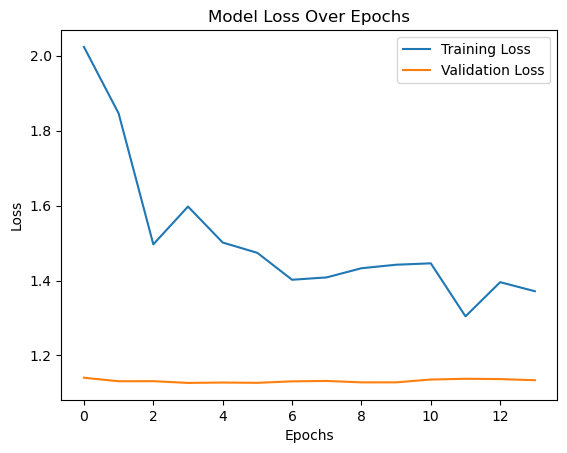

In [282]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("GRU Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 3. Keras Tuner (Model 4) 

In [42]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build model function with hyperparameter choices.
def build_gru_model_tuner(hp): #hp (kerastuner.HyperParameters) - Hyperparameter search space.
    model = Sequential()
    
    # Define hyperparameters using `hp` for various tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates to fight overfitting.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout for LSTM layers.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization factor.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate choices.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay for gradual reduction.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm to prevent exploding gradients.
    units = hp.Choice("units", [32, 64, 128])  # Number of units for LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size choices.


    # Add GRU layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)
        model.add(GRU(units=units, return_sequences=return_sequences,
                       input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
                       kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
        model.add(BatchNormalization()) # Add batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Add dropout to help with overfitting.

    model.add(Dense(1))  # Output layer for a single continuous value.
    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
     # Compile model with specified optimizer and mean squared error loss.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")
    
    return model

# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_gru_model_tuner,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of times to execute each trial.
    directory="gru_tuner_dir",  # Directory to store tuning results.
    project_name="gru_tuning_capstone",  # Tuning project name.
    overwrite=True  # Overwrite existing tuner results if present.
)

# Define early stopping.
early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

# Perform tuning with verbose logging.
tuner.search(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=200,
    callbacks=[early_stopping],
    shuffle=False,
    verbose=1  # Ensure output of each trial.
)

# Retrieve the best model and hyperparameters
best_gru_model = tuner.get_best_models(num_models=1)[0]
best_gru_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters for GRU:", best_gru_hyperparameters.values)
print("Best batch size for GRU:", best_gru_hyperparameters.get("batch_size"))

Trial 30 Complete [00h 00m 14s]
val_loss: 1.5503253936767578

Best val_loss So Far: 1.2928146123886108
Total elapsed time: 00h 09m 38s
Built model with params: dropout_rate=0.4, recurrent_dropout=0.1, l2_lambda=0.0026041400819170504, learning_rate=0.001, learning_rate_decay=0.0, clipnorm=1.0, units=128, num_layers=1, batch_size=256
Best hyperparameters for GRU: {'dropout_rate': 0.4, 'recurrent_dropout': 0.1, 'l2_lambda': 0.0026041400819170504, 'learning_rate': 0.001, 'learning_rate_decay': 0.0, 'clipnorm': 1.0, 'units': 128, 'num_layers': 1, 'batch_size': 256}
Best batch size for GRU: 256


In [289]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.001,
    'l2_lambda': 0.0026041400819170504,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 256
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
     # Select the optimizer with specified parameters
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")

    # Compile the model with the specified optimizer and loss function
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 279ms/step - loss: 3.0605 - val_loss: 1.3507
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 2.4701 - val_loss: 1.3606
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 2.4650 - val_loss: 1.3445
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 2.4217 - val_loss: 1.3507
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 2.4608 - val_loss: 1.3639
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 2.5028 - val_loss: 1.3613
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 2.1993 - val_loss: 1.3506
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 2.0257 - val_loss: 1.3586
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 2.1228 - val_loss: 1.3614
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 1.9697 - val_loss: 1.3452
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 1.9808 - val_loss: 1.3421
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 2.0242 - val_l

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
GRU Model Performance:
Training RMSE: 0.020260312795290877
Test RMSE: 0.02320631633463316
Training MAE: 0.014738559249171803
Test MAE: 0.017572322957416533
Directional Accuracy on Training Data: 61.29779837775203%
Directional Accuracy on Test Data: 52.112676056338024%


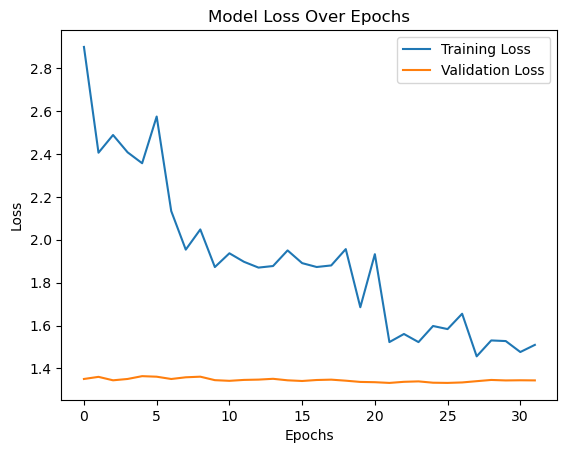

In [290]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("GRU Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Cross Validation Best Model 4

In [25]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.001,
    'l2_lambda': 0.0026041400819170504,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 256
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    optimizer = Adam(learning_rate=params['learning_rate'], 
                     decay=params['learning_rate_decay'], 
                     clipnorm=params['clipnorm'])
    
    # Compile the model
    model.compile(optimizer=optimizer, loss=params['loss_function'])
    
    return model

# Define the number of splits for Time Series Cross-Validation
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize the list to store RMSE scores
tscv_rmse_scores = []

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create the model once and save its initial weights
model = build_best_model(best_params)
initial_weights = model.get_weights()

# Perform TSCV
for fold, (train_index, test_index) in enumerate(tscv.split(X_train_scaled)):
    print(f"Fold {fold + 1}")

    # Reset model to initial weights
    model.set_weights(initial_weights)
    
    # Define train and test sets
    train, test = X_train_scaled[train_index], X_train_scaled[test_index]
    y_train_fold, y_test_fold = y_train_scaled[train_index], y_train_scaled[test_index]
    
    # Create sequences
    X_train_seq, y_train_seq = [], []
    for i in range(len(train) - sequence_length):
        X_train_seq.append(train[i:i + sequence_length])
        y_train_seq.append(y_train_fold[i + sequence_length])
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(test) - sequence_length):
        X_test_seq.append(test[i:i + sequence_length])
        y_test_seq.append(y_test_fold[i + sequence_length])
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        verbose=0,
        callbacks=[early_stopping]
    )
    
    # Predict and evaluate
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    tscv_rmse_scores.append(rmse)
    print(f"Fold {fold + 1} RMSE: {rmse}")

# Calculate the average RMSE across all folds
avg_rmse = np.mean(tscv_rmse_scores)
print(f"Average RMSE from TSCV: {avg_rmse}")

Fold 1
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Fold 1 RMSE: 1.39218035353871
Fold 2
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 2 RMSE: 0.9393159705220238
Fold 3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 3 RMSE: 0.8031534988345941
Fold 4
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold 4 RMSE: 1.118340032489421
Average RMSE from TSCV: 1.0632474638461873


In [26]:
# Parameters for FRWCV
train_window = 300  # Training window size
test_window = 50    # Test window size

# Store RMSEs for each window
rolling_rmse_scores = []

for start in range(0, len(X_train_scaled) - train_window - test_window, test_window):
    print(f"Rolling window starting at index {start}")
    
    # Define train and test sets for the window
    train = X_train_scaled[start:start + train_window]
    test = X_train_scaled[start + train_window:start + train_window + test_window]
    y_train_fold = y_train_scaled[start:start + train_window]
    y_test_fold = y_train_scaled[start + train_window:start + train_window + test_window]
    
    # Create sequences for train and test
    X_train_seq, y_train_seq = [], []
    for i in range(len(train) - sequence_length):
        X_train_seq.append(train[i:i + sequence_length])
        y_train_seq.append(y_train_fold[i + sequence_length])
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(test) - sequence_length):
        X_test_seq.append(test[i:i + sequence_length])
        y_test_seq.append(y_test_fold[i + sequence_length])
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Build and train the model
    model = build_best_model(best_params)
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=best_params['epochs'], 
        batch_size=best_params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        verbose=0,  # Suppress training logs for brevity
        callbacks=[early_stopping]
    )
    
    # Evaluate on the test set
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    rolling_rmse_scores.append(rmse)
    print(f"Rolling window RMSE: {rmse}")

# Calculate average RMSE across rolling windows
avg_rolling_rmse = np.mean(rolling_rmse_scores)
print(f"Average Rolling Window RMSE: {avg_rolling_rmse}")

Rolling window starting at index 0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Rolling window RMSE: 1.2672189604882524
Rolling window starting at index 50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Rolling window RMSE: 1.3447829866904721
Rolling window starting at index 100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Rolling window RMSE: 0.9312400078116914
Rolling window starting at index 150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Rolling window RMSE: 0.754845422750876
Rolling window starting at index 200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Rolling window RMSE: 0.7996244973514081
Rolling window starting at index 250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 478ms/step
Rolling window RMSE: 0.8849869338779565
Rolling window starting at index 300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Rolling window RMSE: 0.9146371691977196
Rolling window starting at index 350
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Rolling window RMSE: 0.4436299407205869
Rolling window starting at index 400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


In [28]:
# Extracting train and val loss:
scaled_train_loss = history.history['loss'][-1]  # Final train loss
scaled_val_loss = history.history['val_loss'][-1]  # Final validation loss

# Descale train and validation loss
descaled_train_loss = np.sqrt(scaled_train_loss) * scaler_y.scale_[0] + scaler_y.mean_[0]
descaled_val_loss = np.sqrt(scaled_val_loss) * scaler_y.scale_[0] + scaler_y.mean_[0]

print(f"Descaled Training Loss: {descaled_train_loss}")
print(f"Descaled Validation Loss: {descaled_val_loss}")

Descaled Training Loss: 0.02694964981545329
Descaled Validation Loss: 0.029828832446420192


In [29]:
# Function to descale RMSE
def descale_rmse(scaled_rmse, scaler_y):
    # Reshape RMSE value to fit scaler requirements
    scaled_rmse_array = np.array(scaled_rmse).reshape(-1, 1)
    # Inverse transform the RMSE
    descaled_rmse_array = scaler_y.inverse_transform(scaled_rmse_array)
    # Return the descaled RMSE as a list
    return descaled_rmse_array.flatten().tolist()

# Descale TSCV RMSE values
descaled_tscv_rmse = descale_rmse(tscv_rmse_scores, scaler_y)
print("Descaled TSCV RMSE Values:", descaled_tscv_rmse)

# Descale FRWCV RMSE values
descaled_frwcv_rmse = descale_rmse(rolling_rmse_scores, scaler_y)
print("Descaled FRWCV RMSE Values:", descaled_frwcv_rmse)

# Calculates average descaled RMSE
average_tscv_rmse = np.mean(descaled_tscv_rmse)
average_frwcv_rmse = np.mean(descaled_frwcv_rmse)
print(f"Average Descaled TSCV RMSE: {average_tscv_rmse}")
print(f"Average Descaled FRWCV RMSE: {average_frwcv_rmse}")

Descaled TSCV RMSE Values: [0.02979594296880376, 0.020613175472628528, 0.01785219808933067, 0.02424326076729588]
Descaled FRWCV RMSE Values: [0.02726209075738302, 0.02883486275136865, 0.0204494185275962, 0.016872651347523904, 0.01778064024259102, 0.019511541229568014, 0.020112761434465946, 0.010562110002547025, 0.017970250983630334, 0.02054881251815269, 0.029705553819247575]
Average Descaled TSCV RMSE: 0.023126144324514708
Average Descaled FRWCV RMSE: 0.02087369941946131


### GRU - Sequence Length = 12 Performance Metrics (Model Comparison) 

| Metrics        | Model 1        | Model 2        | Model 3        | Model 4        |
|-----------------|----------------|----------------|----------------|----------------|
| **Train RMSE** | 0.020340393    | 0.020315578    | 0.020365828    | 0.020260313    |
| **Test RMSE**  | 0.02320085     | 0.023359343    | 0.023297998    | 0.023206316    |
| **Train MAE**  | 0.014789383    | 0.014709749    | 0.014898033    | 0.014738559    |
| **Test MAE**   | 0.017475672    | 0.017628767    | 0.017690958    | 0.017572323    |
| **Train Loss** | 1.518396378    | 1.500672579    | 1.371369123    | 1.509719729    |
| **Val Loss**   | 1.38468802     | 1.273811221    | 1.133797884    | 1.344085455    |
| **Train DA**   | 59%            | 57%            | 54%            | 61.00%         |
| **Test DA**    | 56%            | 53%            | 54%            | 52.00%         |

---

### Descaled Metrics for Sequence Length = 12

#### Training and Validation Loss
| Metric          | Loss       |
|------------------|------------|
| **Training Loss**  | 0.02694965 |
| **Validation Loss**| 0.02982883 |

#### TSCV RMSE Values
| Fold | RMSE       |
|------|------------|
| 1    | 0.02979594 |
| 2    | 0.02061318 |
| 3    | 0.01785220 |
| 4    | 0.02424326 |

**Average TSCV RMSE**: **0.02312614**

- The model when cross validated through different folds it performs similary to the sequence legth = 4, when does not performs well on the first forld. 

#### FRWCV RMSE Values
| Window | RMSE       |
|--------|------------|
| 1      | 0.02726209 |
| 2      | 0.02883486 |
| 3      | 0.02044942 |
| 4      | 0.01687265 |
| 5      | 0.01778064 |
| 6      | 0.01951154 |
| 7      | 0.02011276 |
| 8      | 0.01056211 |
| 9      | 0.01797025 |
| 10     | 0.02054881 |
| 11     | 0.02970555 |

**Average FRWCV RMSE**: **0.02087370**

- Also, in the FRWCV the scores shows the same as the sequence length = 4. Underperforming at the start and at the end windows. 

- When using sequence length of 12, all the models perfomerd similary according to the RMSE and MAE scores and model 1 and 4 are strong candidates for the best performer. However, model 4 has lower train and val loss. 
Thus, **the best performer for the present sequence length is Model 4**.

## Sequence Length = 26 

In [34]:
# Set the sequence length for GRU input, representing the number of time steps.
sequence_length = 26  # Number of time steps used for target prediction, 26 weeks (Six-Months).

# Reshape data into sequences for GRU.
# Initialize empty lists to hold the sequences for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the training data to create sequences of features and corresponding target values.
for i in range(len(X_train_scaled) - sequence_length):
    # Append a sequence of features for the current window.
    X_train_seq.append(X_train_scaled[i:i + sequence_length]) # Sequence of features.
    # Append the target value that comes immediately after the sequence.
    y_train_seq.append(y_train_scaled[i + sequence_length]) # Target value following the sequence.
# Initialize empty lists to hold the sequences for the test set    
X_test_seq, y_test_seq = [], []
# Same process for the test sets.
for i in range(len(X_test_scaled) - sequence_length):
    # Append a sequence of features for the current window in the test set.
    X_test_seq.append(X_test_scaled[i:i + sequence_length])
    # Append the target value immediately after the sequence in the test set.
    y_test_seq.append(y_test_scaled[i + sequence_length])

# Convert lists to numpy arrays to use in Neural Networks.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input data for GRU.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}")
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}")
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")
print(f"Reshaped  y_test_seq shape: { y_test_seq.shape}")

Reshaped X_train_seq shape: (850, 26, 5)
Reshaped y_train_seq shape: (850, 1)
Reshaped X_test_seq shape: (129, 26, 5)
Reshaped  y_test_seq shape: (129, 1)


### 1. Random Search (Two Layers - Model 1)

In [50]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the LSTM model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First GRU layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(GRU(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second GRU layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(GRU(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.01, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 5.0, 'batch_size': 64}
Final Training Loss: 1.1586520671844482
Final Validation Loss: 1.1987735033035278
Running combination 2/30: {'units2': 128, 'units1': 64, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.001, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 2.231224298477173
Final Validation Loss: 2.1928958892822266
Running combination 3/30: {'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 1.0, 'batch_size': 64}
Final Training Loss: 1.380833387374878
Final Validation Loss: 1.174359679222107
Running combination 4/3

In [329]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 64,
    'units2': 32,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 1.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=params['units2'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 22s 70ms/step - loss: 3.0226 - val_loss: 1.2390
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 2.1148 - val_loss: 1.2384
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1.9601 - val_loss: 1.2308
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.7073 - val_loss: 1.2269
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.7432 - val_loss: 1.2676
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.6051 - val_loss: 1.2487
Epoch 7/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.4637 - val_loss: 1.2559
Epoch 8/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.4683 - val_loss: 1.2427
Epoch 9/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.3913 - val_loss: 1.2641
Epoch 10/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1.2690 - val_loss: 1.2535
Epoch 11/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.3377 - val_loss: 1.2498
Epoch 12/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/ste

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
GRU Model Performance:
Training RMSE: 0.02049127626326363
Test RMSE: 0.024112866536011215
Training MAE: 0.014925984805860487
Test MAE: 0.018463097455057104
Directional Accuracy on Training Data: 60.30624263839811%
Directional Accuracy on Test Data: 59.375%


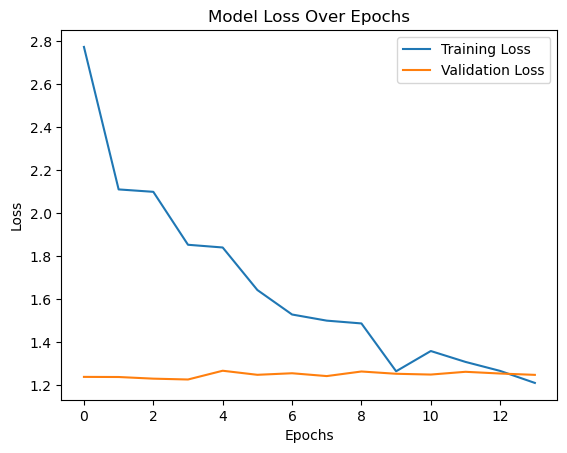

In [330]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("GRU Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### (Three Layers - Model 2)

In [54]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units3': 32, 'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 5.0, 'batch_size': 32}
Final Training Loss: 1.063889503479004
Final Validation Loss: 1.4906423091888428
Running combination 2/30: {'units3': 128, 'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0001, 'l2_lambda': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 3.7834322452545166
Final Validation Loss: 3.5770931243896484
Running combination 3/30: {'units3': 128, 'units2': 64, 'units1': 64, 'recurrent_dropout': 0.1, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.4, 'clipnorm': 5.0, 'batch_size': 256}
Final Training Loss: 2.5251481533050537
Final Valid

In [309]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 64,
    'units2': 64,
    'units3': 64,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 50,
    'dropout_rate': 0.3,
    'clipnorm': 5.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=params['units2'], return_sequences=True, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=params['units3'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 163ms/step - loss: 3.0633 - val_loss: 1.1647
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 2.1874 - val_loss: 1.1522
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 2.2565 - val_loss: 1.1543
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 2.0553 - val_loss: 1.1526
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 1.8163 - val_loss: 1.1521
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 1.7020 - val_loss: 1.1533
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 1.7327 - val_loss: 1.1535
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 1.5736 - val_loss: 1.1418
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 1.5408 - val_loss: 1.1563
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 1.5019 - val_loss: 1.1492
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.5944 - val_loss: 1.1600
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 1

27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
GRU Model Performance:
Training RMSE: 0.020658339202992072
Test RMSE: 0.02408864987797875
Training MAE: 0.015350112369861743
Test MAE: 0.01852388515701742
Directional Accuracy on Training Data: 61.955241460541814%
Directional Accuracy on Test Data: 56.25%


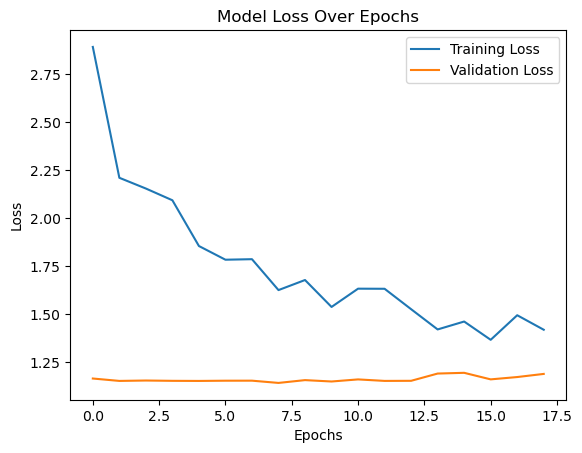

In [310]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("GRU Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2. Optuna (Model 3)

In [58]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def gru_objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of a GRU model.
    Takes a trial object from Optuna and returns the validation loss of the model with given parameters.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate for LSTM layers.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.

    # Initialize the Sequential model.
    model = Sequential()

    # Add GRU layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add GRU layer with specified hyperparameters.
        model.add(GRU(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Set input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))

        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model with mean squared error loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(gru_objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

[I 2024-11-21 00:47:30,047] A new study created in memory with name: no-name-4f8b95f9-5732-44b1-a425-e0acf6d038b6
[I 2024-11-21 00:47:39,062] Trial 0 finished with value: 1.3548427820205688 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0037550037026405905, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 1.3548427820205688.
[I 2024-11-21 00:47:49,810] Trial 1 finished with value: 3.7892794609069824 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.04641587067816149, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 2, 'epochs': 50, 'batch_size': 256}. Best is trial 0 with value: 1.3548427820205688.
[I 2024-11-21 00:48:26,165] Trial 2 finished with value: 3.743288040161133 and parameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.

Best hyperparameters: {'dropout_rate': 0.2, 'recurrent_dropout': 0.1, 'l2_lambda': 0.0010012325682668814, 'learning_rate': 0.001, 'learning_rate_decay': 1e-06, 'clipnorm': 5.0, 'units': 128, 'num_layers': 1, 'epochs': 200, 'batch_size': 64}
Best validation loss: 0.950935423374176


In [333]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.0010012325682668814,
    'epochs': 200,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters.
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping.
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss.
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 165ms/step - loss: 1.7562 - val_loss: 0.9740
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.4582 - val_loss: 0.9972
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.4171 - val_loss: 0.9692
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.4119 - val_loss: 0.9797
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.3716 - val_loss: 0.9820
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 1.2588 - val_loss: 0.9788
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.2849 - val_loss: 0.9643
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.3170 - val_loss: 0.9920
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.1552 - val_loss: 0.9851
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.2508 - val_loss: 0.9777
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 1.1841 - val_loss: 0.9877
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/st

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
GRU Model Performance:
Training RMSE: 0.020336657768969358
Test RMSE: 0.02415841763013274
Training MAE: 0.014873013060246607
Test MAE: 0.01848572467620166
Directional Accuracy on Training Data: 64.075382803298%
Directional Accuracy on Test Data: 60.9375%


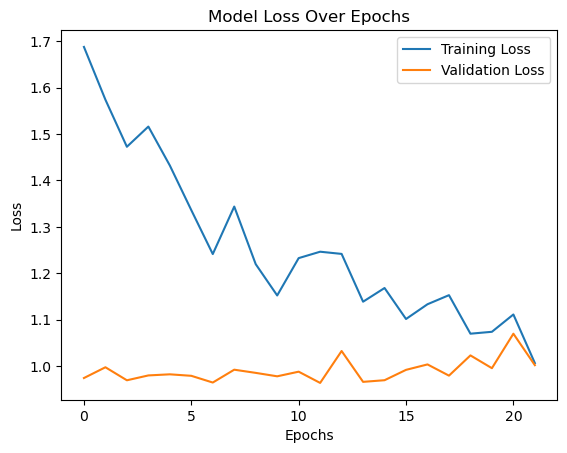

In [334]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("GRU Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 3. Keras Tuner (Model 4) 

In [62]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build model function with hyperparameter choices.
def build_gru_model_tuner(hp): #hp (kerastuner.HyperParameters) - Hyperparameter search space.
    model = Sequential()
    
    # Define hyperparameters using `hp` for various tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates to fight overfitting.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout for LSTM layers.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization factor.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate choices.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay for gradual reduction.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm to prevent exploding gradients.
    units = hp.Choice("units", [32, 64, 128])  # Number of units for LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size choices.


    # Add GRU layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)
        model.add(GRU(units=units, return_sequences=return_sequences,
                       input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
                       kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
        model.add(BatchNormalization()) # Add batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Add dropout to help with overfitting.

    model.add(Dense(1))  # Output layer for a single continuous value.
    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
     # Compile model with specified optimizer and mean squared error loss.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")
    
    return model

# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_gru_model_tuner,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of times to execute each trial.
    directory="gru_tuner_dir",  # Directory to store tuning results.
    project_name="gru_tuning_capstone",  # Tuning project name.
    overwrite=True  # Overwrite existing tuner results if present.
)

# Define early stopping.
early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

# Perform tuning with verbose logging.
tuner.search(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=200,
    callbacks=[early_stopping],
    shuffle=False,
    verbose=1  # Ensure output of each trial.
)

# Retrieve the best model and hyperparameters
best_gru_model = tuner.get_best_models(num_models=1)[0]
best_gru_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters for GRU:", best_gru_hyperparameters.values)
print("Best batch size for GRU:", best_gru_hyperparameters.get("batch_size"))

Trial 30 Complete [00h 00m 32s]
val_loss: 1.145179033279419

Best val_loss So Far: 1.145179033279419
Total elapsed time: 00h 19m 38s
Built model with params: dropout_rate=0.4, recurrent_dropout=0.1, l2_lambda=0.0026041400819170504, learning_rate=0.001, learning_rate_decay=0.0, clipnorm=1.0, units=128, num_layers=1, batch_size=256
Best hyperparameters for GRU: {'dropout_rate': 0.4, 'recurrent_dropout': 0.1, 'l2_lambda': 0.0026041400819170504, 'learning_rate': 0.001, 'learning_rate_decay': 0.0, 'clipnorm': 1.0, 'units': 128, 'num_layers': 1, 'batch_size': 256}
Best batch size for GRU: 256


In [337]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.001,
    'l2_lambda': 0.0026041400819170504,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 256
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
     # Select the optimizer with specified parameters
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")

    # Compile the model with the specified optimizer and loss function
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 3.0126 - val_loss: 1.4638
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - loss: 2.4365 - val_loss: 1.4684
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - loss: 2.1997 - val_loss: 1.4746
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - loss: 2.5595 - val_loss: 1.4829
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - loss: 2.3277 - val_loss: 1.4684
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 2.3167 - val_loss: 1.4668
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - loss: 2.1395 - val_loss: 1.4617
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - loss: 2.0349 - val_loss: 1.4591
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - loss: 1.9364 - val_loss: 1.4560
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - loss: 1.8124 - val_loss: 1.4515
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - loss: 1.8485 - val_loss: 1.4508
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - loss: 2.252

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
GRU Model Performance:
Training RMSE: 0.02052509825300978
Test RMSE: 0.024124932039784067
Training MAE: 0.015032601615871067
Test MAE: 0.01852256212913807
Directional Accuracy on Training Data: 53.35689045936396%
Directional Accuracy on Test Data: 60.15625%


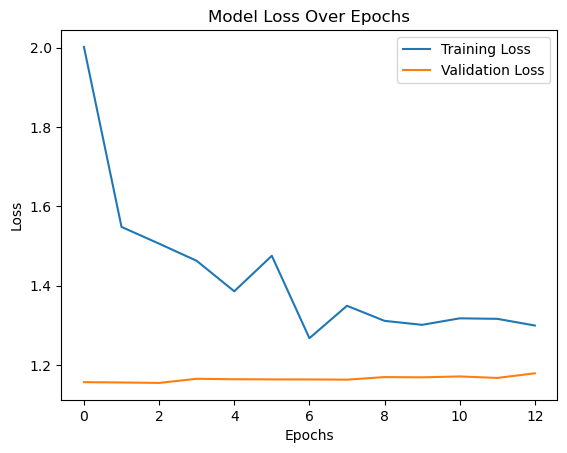

In [64]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("GRU Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Cross Validation Best model (Model 3)

In [36]:
# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.0010012325682668814,
    'epochs': 200,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    optimizer = Adam(learning_rate=params['learning_rate'], 
                     decay=params['learning_rate_decay'], 
                     clipnorm=params['clipnorm'])
    
    # Compile the model
    model.compile(optimizer=optimizer, loss=params['loss_function'])
    
    return model

# Define the number of splits for Time Series Cross-Validation
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize the list to store RMSE scores
tscv_rmse_scores = []

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create the model once and save its initial weights
model = build_best_model(best_params)
initial_weights = model.get_weights()

# Perform TSCV
for fold, (train_index, test_index) in enumerate(tscv.split(X_train_scaled)):
    print(f"Fold {fold + 1}")

    # Reset model to initial weights
    model.set_weights(initial_weights)
    
    # Define train and test sets
    train, test = X_train_scaled[train_index], X_train_scaled[test_index]
    y_train_fold, y_test_fold = y_train_scaled[train_index], y_train_scaled[test_index]
    
    # Create sequences
    X_train_seq, y_train_seq = [], []
    for i in range(len(train) - sequence_length):
        X_train_seq.append(train[i:i + sequence_length])
        y_train_seq.append(y_train_fold[i + sequence_length])
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(test) - sequence_length):
        X_test_seq.append(test[i:i + sequence_length])
        y_test_seq.append(y_test_fold[i + sequence_length])
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        verbose=0,
        callbacks=[early_stopping]
    )
    
    # Predict and evaluate
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    tscv_rmse_scores.append(rmse)
    print(f"Fold {fold + 1} RMSE: {rmse}")

# Calculate the average RMSE across all folds
avg_rmse = np.mean(tscv_rmse_scores)
print(f"Average RMSE from TSCV: {avg_rmse}")

Fold 1
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step
Fold 1 RMSE: 1.4074315975141944
Fold 2
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Fold 2 RMSE: 0.9495876699698728
Fold 3
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Fold 3 RMSE: 0.7620920513741893
Fold 4
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Fold 4 RMSE: 1.1406747327134938
Average RMSE from TSCV: 1.0649465128929376


In [37]:
# Parameters for FRWCV
train_window = 300  # Training window size
test_window = 50    # Test window size

# Store RMSEs for each window
rolling_rmse_scores = []

for start in range(0, len(X_train_scaled) - train_window - test_window, test_window):
    print(f"Rolling window starting at index {start}")
    
    # Define train and test sets for the window
    train = X_train_scaled[start:start + train_window]
    test = X_train_scaled[start + train_window:start + train_window + test_window]
    y_train_fold = y_train_scaled[start:start + train_window]
    y_test_fold = y_train_scaled[start + train_window:start + train_window + test_window]
    
    # Create sequences for train and test
    X_train_seq, y_train_seq = [], []
    for i in range(len(train) - sequence_length):
        X_train_seq.append(train[i:i + sequence_length])
        y_train_seq.append(y_train_fold[i + sequence_length])
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(test) - sequence_length):
        X_test_seq.append(test[i:i + sequence_length])
        y_test_seq.append(y_test_fold[i + sequence_length])
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Build and train the model
    model = build_best_model(best_params)
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=best_params['epochs'], 
        batch_size=best_params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        verbose=0,  # Suppress training logs for brevity
        callbacks=[early_stopping]
    )
    
    # Evaluate on the test set
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    rolling_rmse_scores.append(rmse)
    print(f"Rolling window RMSE: {rmse}")

# Calculate average RMSE across rolling windows
avg_rolling_rmse = np.mean(rolling_rmse_scores)
print(f"Average Rolling Window RMSE: {avg_rolling_rmse}")

Rolling window starting at index 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
Rolling window RMSE: 1.0572590191621813
Rolling window starting at index 50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
Rolling window RMSE: 1.502338620615474
Rolling window starting at index 100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
Rolling window RMSE: 0.9841008283497611
Rolling window starting at index 150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
Rolling window RMSE: 0.7916334572074046
Rolling window starting at index 200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
Rolling window RMSE: 0.7704932179720054
Rolling window starting at index 250
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 882ms/step
Rolling window RMSE: 0.9294135712933032
Rolling window starting at index 300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
Rolling window RMSE: 0.5989977328557264
Rolling window starting at index 350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
Rolling window RMSE: 0.42319736661788454
Rolling window starting at index 400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step

In [38]:
# Extracting train and val loss:
scaled_train_loss = history.history['loss'][-1]  # Final train loss
scaled_val_loss = history.history['val_loss'][-1]  # Final validation loss

# Descale train and validation loss
descaled_train_loss = np.sqrt(scaled_train_loss) * scaler_y.scale_[0] + scaler_y.mean_[0]
descaled_val_loss = np.sqrt(scaled_val_loss) * scaler_y.scale_[0] + scaler_y.mean_[0]

print(f"Descaled Training Loss: {descaled_train_loss}")
print(f"Descaled Validation Loss: {descaled_val_loss}")

Descaled Training Loss: 0.021188794814865474
Descaled Validation Loss: 0.03601840934758383


In [39]:
# Function to descale RMSE
def descale_rmse(scaled_rmse, scaler_y):
    # Reshape RMSE value to fit scaler requirements
    scaled_rmse_array = np.array(scaled_rmse).reshape(-1, 1)
    # Inverse transform the RMSE
    descaled_rmse_array = scaler_y.inverse_transform(scaled_rmse_array)
    # Return the descaled RMSE as a list
    return descaled_rmse_array.flatten().tolist()

# Descale TSCV RMSE values
descaled_tscv_rmse = descale_rmse(tscv_rmse_scores, scaler_y)
print("Descaled TSCV RMSE Values:", descaled_tscv_rmse)

# Descale FRWCV RMSE values
descaled_frwcv_rmse = descale_rmse(rolling_rmse_scores, scaler_y)
print("Descaled FRWCV RMSE Values:", descaled_frwcv_rmse)

# Calculates average descaled RMSE
average_tscv_rmse = np.mean(descaled_tscv_rmse)
average_frwcv_rmse = np.mean(descaled_frwcv_rmse)
print(f"Average Descaled TSCV RMSE: {average_tscv_rmse}")
print(f"Average Descaled FRWCV RMSE: {average_frwcv_rmse}")

Descaled TSCV RMSE Values: [0.030105193668806714, 0.02082145554798326, 0.017019591818610947, 0.024696143279027603]
Descaled FRWCV RMSE Values: [0.023004716150299236, 0.03202963100496409, 0.021521281634658548, 0.017618605279262314, 0.017189942949010037, 0.02041238372750183, 0.013712515212308242, 0.010147797055073356, 0.01807274580316354, 0.014504797545135627, 0.03667647883769103]
Average Descaled TSCV RMSE: 0.023160596078607133
Average Descaled FRWCV RMSE: 0.020444626836278897


### GRU - Sequence Length = 26 (Performance Metrics).

| Metrics        | Model 1        | Model 2        | Model 3        | Model 4        |
|-----------------|----------------|----------------|----------------|----------------|
| **Train RMSE** | 0.020491276    | 0.020658339    | 0.020336658    | 0.020525098    |
| **Test RMSE**  | 0.024112867    | 0.02408865     | 0.024158418    | 0.024124932    |
| **Train MAE**  | 0.014925985    | 0.015350112    | 0.014873013    | 0.015032602    |
| **Test MAE**   | 0.018463097    | 0.018523885    | 0.018485725    | 0.018522562    |
| **Train Loss** | 1.210950732    | 1.418515205    | 1.006243825    | 1.840393305    |
| **Val Loss**   | 1.248393893    | 1.188643813    | 1.00175333     | 1.454532027    |
| **Train DA**   | 60%            | 62%            | 64%            | 53.00%         |
| **Test DA**    | 59%            | 56%            | 61%            | 60.00%         |

---

### Descaled Metrics for Sequence Length = 26

#### TSCV RMSE Values
| Fold | RMSE       |
|------|------------|
| 1    | 0.03010519 |
| 2    | 0.02082146 |
| 3    | 0.01701959 |
| 4    | 0.02469614 |

**Average TSCV RMSE**: **0.02316060**

- While the performance across all 4 folds are the same as the sequence length of 4 and 12, the values of RMSE in the folds that are underperforming are increasing. Suggesting that the longer is the sequence, worse is the performance.  

#### FRWCV RMSE Values
| Window | RMSE       |
|--------|------------|
| 1      | 0.02300472 |
| 2      | 0.03202963 |
| 3      | 0.02152128 |
| 4      | 0.01761861 |
| 5      | 0.01718994 |
| 6      | 0.02041238 |
| 7      | 0.01371252 |
| 8      | 0.01014780 |
| 9      | 0.01807275 |
| 10     | 0.01450480 |
| 11     | 0.03667648 |

**Average FRWCV RMSE**: **0.02044463**

- The model presented good scores at majority of windows. However, it has very high score on the second and last window. Which might indicate represent spikes, noise. 

#### Training and Validation Loss De-scaled. 
| Metric          | Loss       |
|------------------|------------|
| **Training Loss**  | 0.02118879 |
| **Validation Loss**| 0.03601841 |

When using sequence length of 26, model performed similary according to RMSE metrics, however model 3 presented the lower validation loss (original scale) and by observing the convergence plot it shows good indication of good generalization. Thus, **the optimal model for the current sequence length is model 3**. 

## Sequence Length = 52

In [49]:
# Set the sequence length for GRU input, representing the number of time steps.
sequence_length = 52  # Number of time steps used for target prediction, 52 weeks (One year).

# Reshape data into sequences for GRU.
# Initialize empty lists to hold the sequences for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the training data to create sequences of features and corresponding target values.
for i in range(len(X_train_scaled) - sequence_length):
    # Append a sequence of features for the current window.
    X_train_seq.append(X_train_scaled[i:i + sequence_length]) # Sequence of features.
    # Append the target value that comes immediately after the sequence.
    y_train_seq.append(y_train_scaled[i + sequence_length]) # Target value following the sequence.
# Initialize empty lists to hold the sequences for the test set    
X_test_seq, y_test_seq = [], []
# Same process for the test sets.
for i in range(len(X_test_scaled) - sequence_length):
    # Append a sequence of features for the current window in the test set.
    X_test_seq.append(X_test_scaled[i:i + sequence_length])
    # Append the target value immediately after the sequence in the test set.
    y_test_seq.append(y_test_scaled[i + sequence_length])

# Convert lists to numpy arrays to use in Neural Networks.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input data for GRU.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}")
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}")
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")
print(f"Reshaped  y_test_seq shape: { y_test_seq.shape}")

Reshaped X_train_seq shape: (824, 52, 5)
Reshaped y_train_seq shape: (824, 1)
Reshaped X_test_seq shape: (103, 52, 5)
Reshaped  y_test_seq shape: (103, 1)


### 1. Random Search (Two Layers - Model 1)

In [70]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the LSTM model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First GRU layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(GRU(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second GRU layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(GRU(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.01, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 5.0, 'batch_size': 64}
Final Training Loss: 1.1004619598388672
Final Validation Loss: 1.6292967796325684
Running combination 2/30: {'units2': 128, 'units1': 64, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.001, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 2.340627431869507
Final Validation Loss: 2.568591833114624
Running combination 3/30: {'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 1.0, 'batch_size': 64}
Final Training Loss: 1.5593032836914062
Final Validation Loss: 1.6158547401428223
Running combination 4/

In [356]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'units2': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.0005,
    'l2_lambda': 0.001,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 1.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=params['units2'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 255ms/step - loss: 3.8344 - val_loss: 1.5442
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - loss: 2.4000 - val_loss: 1.5161
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - loss: 2.3333 - val_loss: 1.5300
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - loss: 2.2519 - val_loss: 1.5262
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - loss: 2.0539 - val_loss: 1.5193
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - loss: 1.9521 - val_loss: 1.5206
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - loss: 2.2232 - val_loss: 1.5292
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - loss: 1.7739 - val_loss: 1.5144
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - loss: 1.9346 - val_loss: 1.5136
Epoch 10/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - loss: 1.8685 - val_loss: 1.5267
Epoch 11/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - loss: 1.8304 - val_loss: 1.5266
Epoch 12/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
GRU Model Performance:
Training RMSE: 0.020731298592951787
Test RMSE: 0.02546651994221811
Training MAE: 0.015272551667693994
Test MAE: 0.019954113609328483
Directional Accuracy on Training Data: 62.454434993924664%
Directional Accuracy on Test Data: 63.725490196078425%


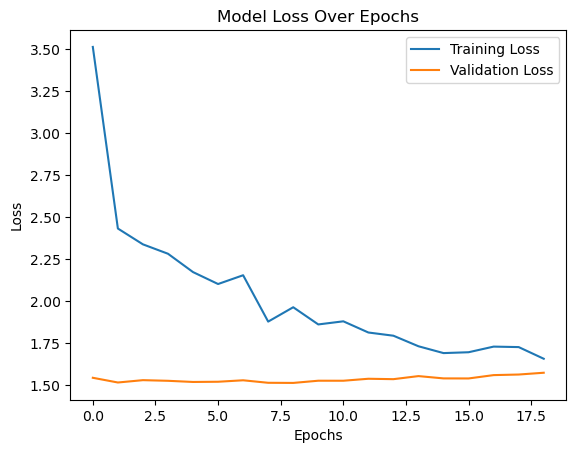

In [357]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("GRU Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### (Three Layers - Model 2)

In [74]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units3': 32, 'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 5.0, 'batch_size': 32}
Final Training Loss: 1.068294644355774
Final Validation Loss: 1.7088396549224854
Running combination 2/30: {'units3': 128, 'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0001, 'l2_lambda': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 3.8654489517211914
Final Validation Loss: 3.8767313957214355
Running combination 3/30: {'units3': 128, 'units2': 64, 'units1': 64, 'recurrent_dropout': 0.1, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.4, 'clipnorm': 5.0, 'batch_size': 256}
Final Training Loss: 2.736686944961548
Final Valida

In [366]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'units2': 64,
    'units3': 128,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0005,
    'l2_lambda': 0.001,
    'epochs': 100,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=params['units2'], return_sequences=True, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=params['units3'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 43s 754ms/step - loss: 2.8546 - val_loss: 1.7099
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 323ms/step - loss: 2.2690 - val_loss: 1.6885
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 316ms/step - loss: 2.0594 - val_loss: 1.6858
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 327ms/step - loss: 2.0533 - val_loss: 1.6853
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 319ms/step - loss: 1.8404 - val_loss: 1.6780
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 322ms/step - loss: 1.7733 - val_loss: 1.6945
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 312ms/step - loss: 1.8506 - val_loss: 1.6939
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 327ms/step - loss: 1.7584 - val_loss: 1.6917
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 287ms/step - loss: 1.6801 - val_loss: 1.6880
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 280ms/step - loss: 1.7938 - val_loss: 1.6752
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 289ms/step - loss: 1.6250 - val_loss: 1.6849
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
GRU Model Performance:
Training RMSE: 0.02081326234748282
Test RMSE: 0.025603522238950897
Training MAE: 0.015419100887151578
Test MAE: 0.020091810683370716
Directional Accuracy on Training Data: 56.13608748481167%
Directional Accuracy on Test Data: 58.82352941176471%


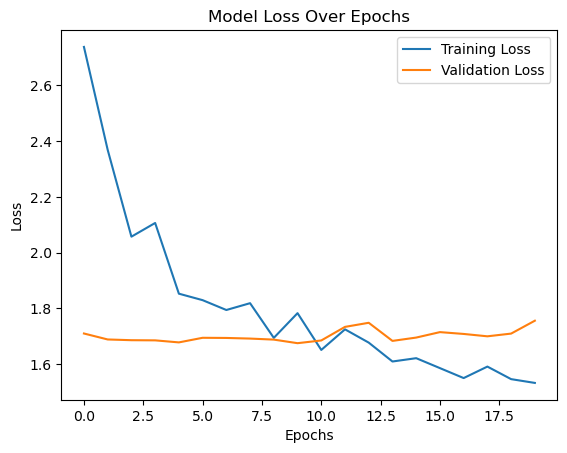

In [367]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("GRU Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2. Optuna (Model 3) 

In [78]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def gru_objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of an GRU model.
    Takes a trial object from Optuna and returns the validation loss of the model with given parameters.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate for LSTM layers.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.

    # Initialize the Sequential model.
    model = Sequential()

    # Add GRU layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add GRU layer with specified hyperparameters.
        model.add(GRU(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Set input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))

        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model with mean squared error loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(gru_objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

[I 2024-11-21 01:57:44,783] A new study created in memory with name: no-name-ace5f0a7-3026-44e2-b1b2-b4002cc1bd75
[I 2024-11-21 01:58:18,244] Trial 0 finished with value: 1.8039352893829346 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0037550037026405905, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 1.8039352893829346.
[I 2024-11-21 01:59:26,507] Trial 1 finished with value: 4.005997657775879 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.04641587067816149, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 2, 'epochs': 50, 'batch_size': 256}. Best is trial 0 with value: 1.8039352893829346.
[I 2024-11-21 02:03:50,788] Trial 2 finished with value: 4.454372882843018 and parameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2

Best hyperparameters: {'dropout_rate': 0.2, 'recurrent_dropout': 0.1, 'l2_lambda': 0.0010012325682668814, 'learning_rate': 0.001, 'learning_rate_decay': 1e-06, 'clipnorm': 5.0, 'units': 128, 'num_layers': 1, 'epochs': 200, 'batch_size': 64}
Best validation loss: 1.4060945510864258


In [362]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.0010012325682668814,
    'epochs': 200,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters.
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping.
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss.
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step - loss: 1.9767 - val_loss: 1.4326
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 1.4733 - val_loss: 1.4267
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 1.4628 - val_loss: 1.4282
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 1.3009 - val_loss: 1.4348
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 1.3873 - val_loss: 1.4328
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 1.3625 - val_loss: 1.4404
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 1.3832 - val_loss: 1.4345
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 1.4830 - val_loss: 1.4316
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 1.2970 - val_loss: 1.4264
Epoch 10/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 1.3318 - val_loss: 1.4320
Epoch 11/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 1.2688 - val_loss: 1.4372
Epoch 12/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
GRU Model Performance:
Training RMSE: 0.02057806743674316
Test RMSE: 0.0256348150469759
Training MAE: 0.015090902795519086
Test MAE: 0.02023828217703901
Directional Accuracy on Training Data: 62.454434993924664%
Directional Accuracy on Test Data: 53.92156862745098%


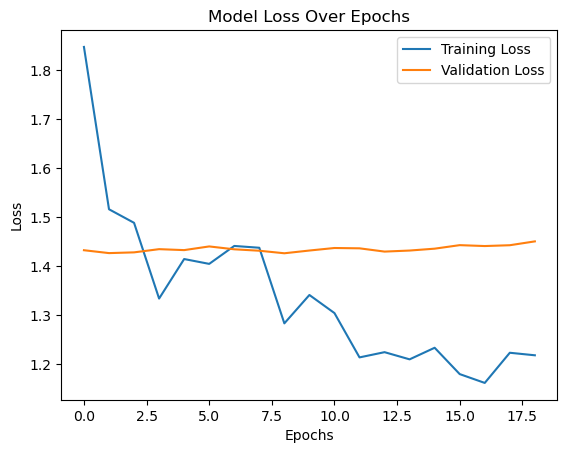

In [363]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("GRU Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 3. Keras Tuner (Model 4) 

In [82]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build model function with hyperparameter choices.
def build_gru_model_tuner(hp): #hp (kerastuner.HyperParameters) - Hyperparameter search space.
    model = Sequential()
    
    # Define hyperparameters using `hp` for various tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates to fight overfitting.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout for LSTM layers.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization factor.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate choices.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay for gradual reduction.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm to prevent exploding gradients.
    units = hp.Choice("units", [32, 64, 128])  # Number of units for LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size choices.


    # Add GRU layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)
        model.add(GRU(units=units, return_sequences=return_sequences,
                       input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
                       kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
        model.add(BatchNormalization()) # Add batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Add dropout to help with overfitting.

    model.add(Dense(1))  # Output layer for a single continuous value.
    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
     # Compile model with specified optimizer and mean squared error loss.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")
    
    return model

# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_gru_model_tuner,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of times to execute each trial.
    directory="gru_tuner_dir",  # Directory to store tuning results.
    project_name="gru_tuning_capstone",  # Tuning project name.
    overwrite=True  # Overwrite existing tuner results if present.
)

# Define early stopping.
early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

# Perform tuning with verbose logging.
tuner.search(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=200,
    callbacks=[early_stopping],
    shuffle=False,
    verbose=1  # Ensure output of each trial.
)

# Retrieve the best model and hyperparameters
best_gru_model = tuner.get_best_models(num_models=1)[0]
best_gru_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters for GRU:", best_gru_hyperparameters.values)
print("Best batch size for GRU:", best_gru_hyperparameters.get("batch_size"))

Trial 30 Complete [00h 01m 01s]
val_loss: 1.5216517448425293

Best val_loss So Far: 1.4135634899139404
Total elapsed time: 01h 17m 16s
Built model with params: dropout_rate=0.4, recurrent_dropout=0.1, l2_lambda=0.0026041400819170504, learning_rate=0.001, learning_rate_decay=0.0, clipnorm=1.0, units=128, num_layers=1, batch_size=256
Best hyperparameters for GRU: {'dropout_rate': 0.4, 'recurrent_dropout': 0.1, 'l2_lambda': 0.0026041400819170504, 'learning_rate': 0.001, 'learning_rate_decay': 0.0, 'clipnorm': 1.0, 'units': 128, 'num_layers': 1, 'batch_size': 256}
Best batch size for GRU: 256


In [83]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0.0,
    'learning_rate': 0.001,
    'l2_lambda': 0.0026041400819170504,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 256
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(GRU(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
     # Select the optimizer with specified parameters
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")

    # Compile the model with the specified optimizer and loss function
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 472ms/step - loss: 3.0932 - val_loss: 1.6390
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step - loss: 2.5332 - val_loss: 1.6712
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - loss: 2.6325 - val_loss: 1.6663
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step - loss: 2.5113 - val_loss: 1.6520
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - loss: 2.4119 - val_loss: 1.6494
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - loss: 2.0771 - val_loss: 1.6467
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - loss: 1.8716 - val_loss: 1.6571
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step - loss: 2.1459 - val_loss: 1.6645
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - loss: 2.3030 - val_loss: 1.6643
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step - loss: 1.9608 - val_loss: 1.6512
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step - loss: 2.3196 - val_loss: 1.6488
Final Training Loss: 2.406024932861328
Final Validation Loss: 1

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
GRU Model Performance:
Training RMSE: 0.0206902047220596
Test RMSE: 0.02575656234822096
Training MAE: 0.015029414362832866
Test MAE: 0.020253048888592088
Directional Accuracy on Training Data: 52.0048602673147%
Directional Accuracy on Test Data: 42.15686274509804%


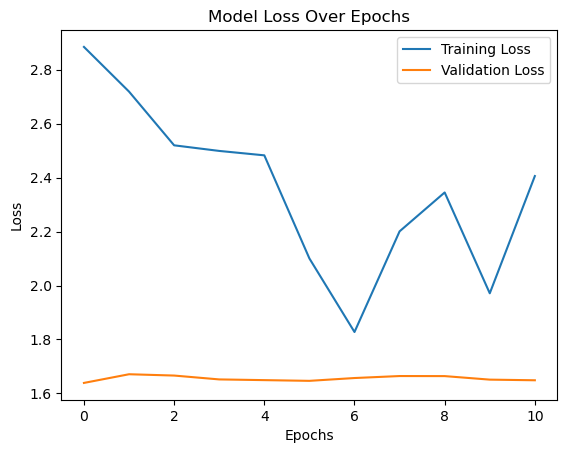

In [84]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("GRU Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Cross Validation on the best performer (Model 1)

In [51]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Best hyperparameters
best_params = {
    'units1': 128,
    'units2': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.0005,
    'l2_lambda': 0.001,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 1.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second GRU layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    optimizer = Adam(learning_rate=params['learning_rate'], 
                     decay=params['learning_rate_decay'], 
                     clipnorm=params['clipnorm'])
    
    # Compile the model
    model.compile(optimizer=optimizer, loss=params['loss_function'])
    
    return model

# Define the number of splits for Time Series Cross-Validation
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize the list to store RMSE scores
tscv_rmse_scores = []

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create the model once and save its initial weights
model = build_best_model(best_params)
initial_weights = model.get_weights()

# Perform TSCV
for fold, (train_index, test_index) in enumerate(tscv.split(X_train_scaled)):
    print(f"Fold {fold + 1}")

    # Reset model to initial weights
    model.set_weights(initial_weights)
    
    # Define train and test sets
    train, test = X_train_scaled[train_index], X_train_scaled[test_index]
    y_train_fold, y_test_fold = y_train_scaled[train_index], y_train_scaled[test_index]
    
    # Create sequences
    X_train_seq, y_train_seq = [], []
    for i in range(len(train) - sequence_length):
        X_train_seq.append(train[i:i + sequence_length])
        y_train_seq.append(y_train_fold[i + sequence_length])
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(test) - sequence_length):
        X_test_seq.append(test[i:i + sequence_length])
        y_test_seq.append(y_test_fold[i + sequence_length])
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        verbose=0,
        callbacks=[early_stopping]
    )
    
    # Predict and evaluate
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    tscv_rmse_scores.append(rmse)
    print(f"Fold {fold + 1} RMSE: {rmse}")

# Calculate the average RMSE across all folds
avg_rmse = np.mean(tscv_rmse_scores)
print(f"Average RMSE from TSCV: {avg_rmse}")

Fold 1
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step
Fold 1 RMSE: 1.5008037790439925
Fold 2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Fold 2 RMSE: 0.7810640727637979
Fold 3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Fold 3 RMSE: 0.7555785076727245
Fold 4
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Fold 4 RMSE: 1.198729163871953
Average RMSE from TSCV: 1.059043880838117


In [402]:
# Parameters for FRWCV
train_window = 300  # Training window size
test_window = 53    # Test window size

# Store RMSEs for each window
rolling_rmse_scores = []

for start in range(0, len(X_train_scaled) - train_window - test_window, test_window):
    print(f"Rolling window starting at index {start}")
    
    # Define train and test sets for the window
    train = X_train_scaled[start:start + train_window]
    test = X_train_scaled[start + train_window:start + train_window + test_window]
    y_train_fold = y_train_scaled[start:start + train_window]
    y_test_fold = y_train_scaled[start + train_window:start + train_window + test_window]
    
    # Create sequences for train and test
    X_train_seq, y_train_seq = [], []
    for i in range(len(train) - sequence_length):
        X_train_seq.append(train[i:i + sequence_length])
        y_train_seq.append(y_train_fold[i + sequence_length])
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(test) - sequence_length):
        X_test_seq.append(test[i:i + sequence_length])
        y_test_seq.append(y_test_fold[i + sequence_length])
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Build and train the model
    model = build_best_model(best_params)
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=best_params['epochs'], 
        batch_size=best_params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        verbose=0,  # Suppress training logs for brevity
        callbacks=[early_stopping]
    )
    
    # Evaluate on the test set
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    rolling_rmse_scores.append(rmse)
    print(f"Rolling window RMSE: {rmse}")

# Calculate average RMSE across rolling windows
avg_rolling_rmse = np.mean(rolling_rmse_scores)
print(f"Average Rolling Window RMSE: {avg_rolling_rmse}")

Rolling window starting at index 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
Rolling window RMSE: 0.5838685466760468
Rolling window starting at index 53
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step
Rolling window RMSE: 0.5203541562302694
Rolling window starting at index 106
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Rolling window RMSE: 0.33111092884401416
Rolling window starting at index 159
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Rolling window RMSE: 0.006750132876199827
Rolling window starting at index 212
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Rolling window RMSE: 0.8284923051600822
Rolling window starting at index 265
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
Rolling window RMSE: 0.6230209224222404
Rolling window starting at index 318
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Rolling window RMSE: 0.2384357619215617
Rolling window starting at index 371
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
Rolling window RMSE: 0.25731234026442384
Rolling window starting at index 424
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Rolling

In [53]:
# Extracting train and val loss:
scaled_train_loss = history.history['loss'][-1]  # Final train loss
scaled_val_loss = history.history['val_loss'][-1]  # Final validation loss

# Descale train and validation loss
descaled_train_loss = np.sqrt(scaled_train_loss) * scaler_y.scale_[0] + scaler_y.mean_[0]
descaled_val_loss = np.sqrt(scaled_val_loss) * scaler_y.scale_[0] + scaler_y.mean_[0]

print(f"Descaled Training Loss: {descaled_train_loss}")
print(f"Descaled Validation Loss: {descaled_val_loss}")

Descaled Training Loss: 0.028713296231327252
Descaled Validation Loss: 0.027121839891951775


In [55]:
# Function to descale RMSE
def descale_rmse(scaled_rmse, scaler_y):
    # Reshape RMSE value to fit scaler requirements
    scaled_rmse_array = np.array(scaled_rmse).reshape(-1, 1)
    # Inverse transform the RMSE
    descaled_rmse_array = scaler_y.inverse_transform(scaled_rmse_array)
    # Return the descaled RMSE as a list
    return descaled_rmse_array.flatten().tolist()

# Descale TSCV RMSE values
descaled_tscv_rmse = descale_rmse(tscv_rmse_scores, scaler_y)
print("Descaled TSCV RMSE Values:", descaled_tscv_rmse)

# Descale FRWCV RMSE values
descaled_frwcv_rmse = descale_rmse(rolling_rmse_scores, scaler_y)
print("Descaled FRWCV RMSE Values:", descaled_frwcv_rmse)

# Calculates average descaled RMSE
average_tscv_rmse = np.mean(descaled_tscv_rmse)
average_frwcv_rmse = np.mean(descaled_frwcv_rmse)
print(f"Average Descaled TSCV RMSE: {average_tscv_rmse}")
print(f"Average Descaled FRWCV RMSE: {average_frwcv_rmse}")

Descaled TSCV RMSE Values: [0.031998508899046874, 0.017404289021320348, 0.016887516169410415, 0.02587331764610782]
Descaled FRWCV RMSE Values: [0.023004716150299236, 0.03202963100496409, 0.021521281634658548, 0.017618605279262314, 0.017189942949010037, 0.02041238372750183, 0.013712515212308242, 0.010147797055073356, 0.01807274580316354, 0.014504797545135627, 0.03667647883769103]
Average Descaled TSCV RMSE: 0.023040907933971365
Average Descaled FRWCV RMSE: 0.020444626836278897


### GRU - Sequence Length = 52 Performance Metrics

| Metrics        | Model 1        | Model 2        | Model 3        | Model 4        |
|-----------------|----------------|----------------|----------------|----------------|
| **Train RMSE** | 0.020731299    | 0.020813262    | 0.020578067    | 0.020690205    |
| **Test RMSE**  | 0.02546652     | 0.025603522    | 0.025634815    | 0.025756562    |
| **Train MAE**  | 0.015272552    | 0.015419101    | 0.015090903    | 0.015029414    |
| **Test MAE**   | 0.019954114    | 0.020091811    | 0.020238282    | 0.020253049    |
| **Train Loss** | 1.657401443    | 1.532637119    | 1.217889905    | 2.406024933    |
| **Val Loss**   | 1.574157357    | 1.75578177     | 1.450689793    | 1.648834944    |
| **Train DA**   | 62%            | 56%            | 62%            | 52%            |
| **Test DA**    | 64%            | 59%            | 54%            | 42%            |

### Descaled Metrics for Sequence Length = 52

#### Training and Validation Loss
| Metric          | Loss       |
|------------------|------------|
| **Training Loss**  | 0.02871330 |
| **Validation Loss**| 0.02712184 |

#### TSCV RMSE Values
| Fold | RMSE       |
|------|------------|
| 1    | 0.03199851 |
| 2    | 0.01740429 |
| 3    | 0.01688752 |
| 4    | 0.02587332 |

- The sequence length of 52 als shows that the longer the SL, the higher the rmse (slightly lower than the SL = 26).  
---

By observing the models that used sequence length of 52, it was observable that they not perform well like shorter sequence legth. However, between the four models tested, the one that stands out is the model 1. The model has the lowest accuracy metrics and it shows better convergence between train and val loss than the other 3. Therefore, **Model 1 is the best performer using sequence length of 52**.

## Best GRU Models Across Sequence Lengths (SL)

| Metrics        | SL = 4 (Model 1) | SL = 12 (Model 4) | SL = 26 (Model 3) | SL = 52 (Model 1) |
|-----------------|------------------|-------------------|-------------------|-------------------|
| **Train RMSE** | 0.02013539       | 0.020260313       | 0.020336658       | 0.020731299       |
| **Test RMSE**  | 0.022516987      | 0.023206316       | 0.024158418       | 0.02546652        |
| **Train MAE**  | 0.014490918      | 0.014738559       | 0.014873013       | 0.015272552       |
| **Test MAE**   | 0.017158276      | 0.017572323       | 0.018485725       | 0.019954114       |
| **Train Loss** | 0.912656903      | 1.509719729       | 1.006243825       | 1.657401443       |
| **Val Loss**   | 1.27573967       | 1.344085455       | 1.00175333        | 1.574157357       |
| **Train DA**   | 67%              | 61%               | 64%               | 62%               |
| **Test DA**    | 61%              | 52%               | 61%               | 64%               |
| **TSCV RMSE**  | 1.044922189      | 1.063247464       | 1.060827084       | 1.056222142       |
| **FRWCV RMSE** | 0.921729412      | 1.387722653       | 0.928607102       | 0.750164828       
---
### Cross-Validation Results Across Sequence Lengths (SL)

| **Sequence Length (SL)** | **Fold 1 RMSE** | **Fold 2 RMSE** | **Fold 3 RMSE** | **Fold 4 RMSE** | **Average TSCV RMSE** | **Training Loss** | **Validation Loss** |
|---------------------------|-----------------|-----------------|-----------------|-----------------|------------------------|-------------------|---------------------|
| **SL = 4**               | 0.02947509      | 0.02077223      | 0.01716908      | 0.02376763      | **0.02279601**         | 0.02821466        | 0.02880561          |
| **SL = 12**              | 0.02979594      | 0.02061318      | 0.01785220      | 0.02424326      | **0.02312614**         | 0.02694965        | 0.02982883          |
| **SL = 26**              | 0.03010519      | 0.02082146      | 0.01701959      | 0.02469614      | **0.02316060**         | 0.02118879        | 0.03601841          |
| **SL = 52**              | 0.03199851      | 0.01740429      | 0.01688752      | 0.02587332      | **0.02304091**         | 0.02871330        | 0.02712184          |

---

| **Sequence Length (SL)** | **Window 1 RMSE** | **Window 2 RMSE** | **Window 3 RMSE** | **Window 4 RMSE** | **Window 5 RMSE** | **Window 6 RMSE** | **Window 7 RMSE** | **Window 8 RMSE** | **Window 9 RMSE** | **Window 10 RMSE** | **Window 11 RMSE** | **Average FRWCV RMSE** |
|---------------------------|-------------------|-------------------|-------------------|-------------------|-------------------|-------------------|-------------------|-------------------|-------------------|--------------------|--------------------|------------------------|
| **SL = 4**               | 0.02594688        | 0.02700570        | 0.01919830        | 0.01645224        | 0.01662672        | 0.01924344        | 0.01863647        | 0.01204935        | 0.01677555        | 0.02292363         | 0.02832073         | **0.02028900**         |
| **SL = 12**              | 0.02726209        | 0.02883486        | 0.02044942        | 0.01687265        | 0.01778064        | 0.01951154        | 0.02011276        | 0.01056211        | 0.01797025        | 0.02054881         | 0.02970555         | **0.02087370**         |
| **SL = 26**              | 0.02300472        | 0.03202963        | 0.02152128        | 0.01761861        | 0.01718994        | 0.02041238        | 0.01371252        | 0.01014780        | 0.01807275        | 0.01450480         | 0.03667648         | **0.02044463**         |


---
The final score metric table is composed by the best model of sequence length, the best performer is chosen upon not only lower but balanced metrics. And according to the table:
- SL = 4: Has the lowest RMSE and MAE metrics for both train and test sets. Also, it has competitive train and val loss. The model also has the lowest scores for both cross-validation test.
- SL = 23: It has the second best metrics.  
- SL = 36: Dspite having higher accuracy metrics, the model showed learning efficiency, registering the lowest validation loss and the good convergence.
- SL = 52: Has the highest metrics of all models.

Before the ultimate selection, models were evaluated using two types of cross-validation techniques the time-series and fixed-rolling window. The SL=4 performed better when spliting the set into 4 different folds, however the SL=52 had better performance when evaluate on fixed windows. **Thus, analysing cross-validations and metric scores, the best candidate for the GRU model is with sequence length of 4 (model 1)**.  